# Via Nielson 

# CCD Lab. Mean-Variance Test of a CCD

The instructions for this lab are contained in the google doc  "Astro 361 F20 Lab3 Instructions" along with "Astro 361 F20 Lab3 Template"



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization
% ls


Mounted at /content/drive
/content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization
 Astro361_F20_Lab3_Instructions.docx  'Student Data'/
'Digital Logsheets.xlsx'               vianie_Astro361_Lab3Report.docx
'Example CCD Data'/                    vianie_ccd.ipynb
 Group1-Rebecca/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.io import fits
import numpy as np
import glob


In [ ]:
# This cell shows how you can grab a list of files based on a wildcard search
#datapath='/content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Example CCD Data/JDM_Lab3_Example_Data'
datapath='/content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Rebecca'
files=glob.glob(datapath+"/*bias.fit")
files.sort()
nbias=len(files)
print("Found %i Files"%nbias)





Found 10 Files


In [ ]:
# You will see that these frames are quite large and slow to analyze. Also, the "flat field" image is not totally flat
# which can complicate analysis.  In the next line we define [i0:i1,j0:j1] subarray that will be used for analysis. 
# You can choose your own range or keep this range.

subarray=[1250,1350,1650,1750] # what part of chip to read (avoid bad pixels and flatfield should be flat)

# Load all data into a tuple (list) of arrays
bias_tuple = []
for f in files:
    data0=fits.getdata(f, ext=0).astype(np.int)
    bias_tuple.append(data0)
    print('Working on file %s' % f)
    print(" w/ SHAPE:",data0.shape)

# Turn this "list" of arrays into a 3-dimensional data cube (dimx,dimy, n_files) for easier analysis.
bias_cube_raw = np.dstack(bias_tuple)
print('Raw Bias Data Cube Shape: ',bias_cube_raw.shape)
bias_cube = bias_cube_raw[subarray[0]:subarray[1],subarray[2]:subarray[3],:]
print('Cropped Bias Data Cube Shape: ',bias_cube.shape)


Working on file /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Rebecca/Group1-0001_bias.fit
 w/ SHAPE: (2504, 3326)
Working on file /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Rebecca/Group1-0002_bias.fit
 w/ SHAPE: (2504, 3326)
Working on file /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Rebecca/Group1-0003_bias.fit
 w/ SHAPE: (2504, 3326)
Working on file /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Rebecca/Group1-0004_bias.fit
 w/ SHAPE: (2504, 3326)
Working on file /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Rebecca/Group1-0005_bias.fit
 w/ SHAPE: (2504, 3326)
Working on file /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Rebecca/Group1-0006_bias.fit
 w/ SHAPE: (2504, 3326)
Working on file /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Reb

# Looking at the Bias Frames

887 1068


(900.0, 1100.0)

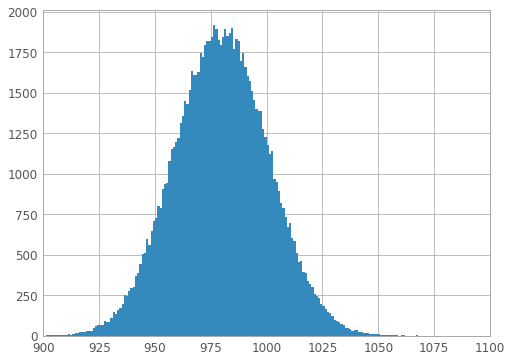

In [ ]:
# Lets look at some statistics in these series of bias frames.
print(bias_cube.min(),bias_cube.max())
bins=np.arange(bias_cube.min(), bias_cube.max() + 1, 1)

# does this look Gaussian to you? 
plt.hist(bias_cube.ravel(),bins=bins)
plt.xlim(900,1100)

In [ ]:
# create a master bias by averaging many together.  
# The noise in this master should be reduced by a factor of sqrt(Number)
master_bias = np.mean(bias_cube,axis=2)
master_bias_raw = np.mean(bias_cube_raw,axis=2)
# notice how we can take the average along any axis of this data cube. 



#Method 1: spatial variation of values

Method 1: RMS (ADU) in Bias Frames: 19.941369813896568 0.10182861589319474


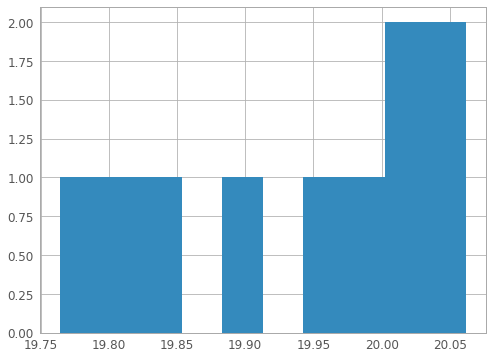

In [ ]:
#Method 1. Look at the rms in a region in each frame after bias-correction by master-bias.
bias_rms_list1 = np.zeros(nbias) #create an estimate for each frame.
bias_mean_list1 = np.zeros(nbias)
for i in range(nbias):
  bias_rms_list1[i]=np.std(bias_cube[:,:,i]-master_bias) # ignore noise in master bias
  bias_mean_list1[i]=np.mean(bias_cube[:,:,i]-master_bias)

plt.hist(bias_rms_list1)
print("Method 1: RMS (ADU) in Bias Frames:", bias_rms_list1.mean(),bias_rms_list1.std())


# Method 2: temporal variation of values

Method 2: RMS (ADU) in Bias Frames: 20.458958893479224 4.880085939069636
20.458958893479224
23.815238772705165


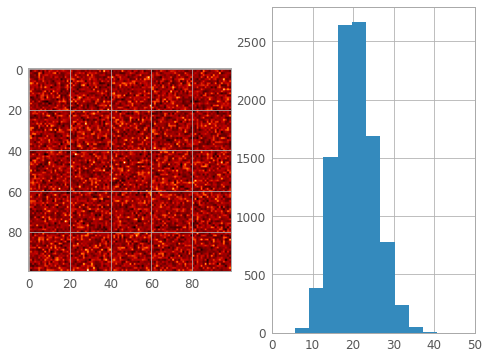

In [ ]:
#Method 2 is to look at the rms in the "depth" direction of the cube, which is time

# here we will get an estimate of the mean and standard devaition for EACH PIXEL!
dims=bias_cube.shape
bias_rms_list2 = np.zeros((dims[0],dims[1]))
bias_means_list2 = np.zeros((dims[0],dims[1]))

#loop over x,y dimensions
for i in range(dims[0]):
  #print('progress ',i,dims[0])
  for j in range(dims[1]):
    datalist = bias_cube[i,j,:]-master_bias[i,j]
    bias_rms_list2[i,j]=np.std(datalist,ddof=1) # why ddof=1 ? what happens if you leave this out?
    bias_means_list2[i,j]=datalist.mean()
plt.subplot(1,2,1)
plt.imshow(bias_rms_list2)
#plt.title("Read Noise -Image-")
plt.subplot(1,2,2)
plt.hist(bias_rms_list2.ravel())
plt.xlim(0,50)
print("Method 2: RMS (ADU) in Bias Frames:", bias_rms_list2.mean(),bias_rms_list2.std())
print(np.mean(bias_rms_list2))
print(np.var(bias_rms_list2))

# Method 3: simple difference of two frames

In [ ]:
#Method 3.  Subtract two flat field frames and look at the standard deviation of the difference .
# this is similar to Method 1 but is actually better since it not corrupted by variations in mean level across image.
# Note you have to divide by root(2) to since noise adds in quadrature when doing a difference of two noisy datasets.
print(  (bias_cube[:,:,2]-bias_cube[:,:,1]).std() /np.sqrt(2))

20.898558551249415


In [ ]:
 #So it seems the readnoise is about 20.5 ADU

# Analyzing one of the Flat Field datasets

In [ ]:
# lets write a little routine to read in frames
# for this routine you need to pass a searchstring and optionally a subarray range
def read_datacube(searchstring,subarray=None):

  files=glob.glob(searchstring)
  files.sort()
  data_tuple = []
  for f in files:
    data0=fits.getdata(f, ext=0).astype(np.int)
    data_tuple.append(data0)
    print('Working on file %s' % f)
    print(" w/ SHAPE:",data0.shape)
  data_cube_raw = np.dstack(data_tuple)
  print('Raw Bias Data Cube Shape: ',data_cube_raw.shape)
  raw_dims=data_cube_raw.shape
  if subarray == None:
    i0=0
    j0=0
    i1=raw_dims[0]
    j1=raw_dims[1]
  else:
    i0=subarray[0]
    i1=subarray[1]
    j0=subarray[2]
    j1=subarray[3]
  data_cube = data_cube_raw[i0:i1,j0:j1,:]
  print('Cropped Bias Data Cube Shape: ',data_cube.shape)

  return(data_cube,data_cube_raw)

In [ ]:
searchstring = datapath+"/*flat30.fit"
data_cube,data_cube_raw = read_datacube(searchstring,subarray=subarray)
print('Data Dims: ',data_cube.shape)
plt.subplot(1,2,1)
plt.imshow(np.mean(data_cube_raw,axis=2)-master_bias_raw)
plt.subplot(1,2,2)
plt.imshow(np.mean(data_cube,axis=2)-master_bias)


Working on file /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Rebecca/Group1-0001_flat30.fit
 w/ SHAPE: (2504, 3326)
Working on file /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Rebecca/Group1-0002_flat30.fit
 w/ SHAPE: (2504, 3326)
Working on file /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Rebecca/Group1-0003_flat30.fit
 w/ SHAPE: (2504, 3326)
Working on file /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Rebecca/Group1-0004_flat30.fit
 w/ SHAPE: (2504, 3326)


In [ ]:
#Method 1. Look at the rms in a region in each frame after bias-correction by master-bias.
dimx,dimy,nflat=data_cube.shape
flat30_rms_list1 = np.zeros(nflat) #create an estimate for each frame.
flat30_mean_list1 = np.zeros(nflat)
for i in range(nflat):
  flat30_rms_list1[i] =np.std(data_cube[:,:,i]-master_bias) # ignore noise in master bias
  flat30_mean_list1[i]=np.mean(data_cube[:,:,i]-master_bias)

plt.hist(flat30_rms_list1)
print("Method 1: RMS (ADU) in Flat30 Frames:", flat30_rms_list1.mean(),flat30_rms_list1.std())
#\ Measure the mean and rms of each master frame 


In [ ]:
#Method 2 is to look at the rms in the "depth" direction of the cube.

dims=data_cube.shape
flat30_rms_list2 = np.zeros((dims[0],dims[1]))
flat30_means_list2 = np.zeros((dims[0],dims[1]))

for i in range(dims[0]):
  #print('progress ',i,dims[0])
  for j in range(dims[1]):
    datalist = data_cube[i,j,:]-master_bias[i,j]
    flat30_rms_list2[i,j]=np.std(datalist,ddof=1)
    flat30_means_list2[i,j]=datalist.mean()
plt.subplot(1,2,1)
plt.imshow(flat30_rms_list2)
#plt.title('Noise in Flat30 -Image-')
plt.subplot(1,2,2)
plt.hist(flat30_rms_list2.ravel(),bins=200);
plt.xlim(0,500)
plt.show()#
print("Method 2: RMS (ADU) in Bias Frames:", flat30_rms_list2.mean(),flat30_rms_list2.std())
print("Method 2: mean (ADU) in Bias Frames:", flat30_means_list2.mean(),flat30_means_list2.std())
plt.subplot(1,2,1)
plt.imshow(flat30_means_list2)
#plt.title('Flat30 -Image-')
plt.subplot(1,2,2)
plt.hist(flat30_means_list2.ravel(),bins=200);
#plt.xlim(0,500)


In [ ]:
#Method 3.  Subtract two flat field frames and look at the standard deviation of the difference .
# you have to divide by root(2) to since noise adds in quadrature when doing a different of two noisy datasets.
print(  (data_cube[:,:,2]-data_cube[:,:,1]).std() /np.sqrt(2))

# Next Steps - My Work

Collect the mean and variance +/- error for each set of integration times and make plot (like in Lab 2).

In addition, you will need to make a plot flux vs time and see if the graph is linear -- and quantify deviation from linearity.


Working on file /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Rebecca/Group1-0001_flat5.fit
 w/ SHAPE: (2504, 3326)
Working on file /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Rebecca/Group1-0002_flat5.fit
 w/ SHAPE: (2504, 3326)
Working on file /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Rebecca/Group1-0003_flat5.fit
 w/ SHAPE: (2504, 3326)
Working on file /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Rebecca/Group1-0004_flat5.fit
 w/ SHAPE: (2504, 3326)
Working on file /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Rebecca/Group1-0005_flat5.fit
 w/ SHAPE: (2504, 3326)
Raw Bias Data Cube Shape:  (2504, 3326, 5)
Cropped Bias Data Cube Shape:  (100, 100, 5)
Working on file /content/drive/My Drive/vianie_ASTRO361/Lab 3 CCD Camera Characterization/Group1-Rebecca/Group1-0001_flat10.fit
 w/ SHAPE: (2504, 3326)
Worki

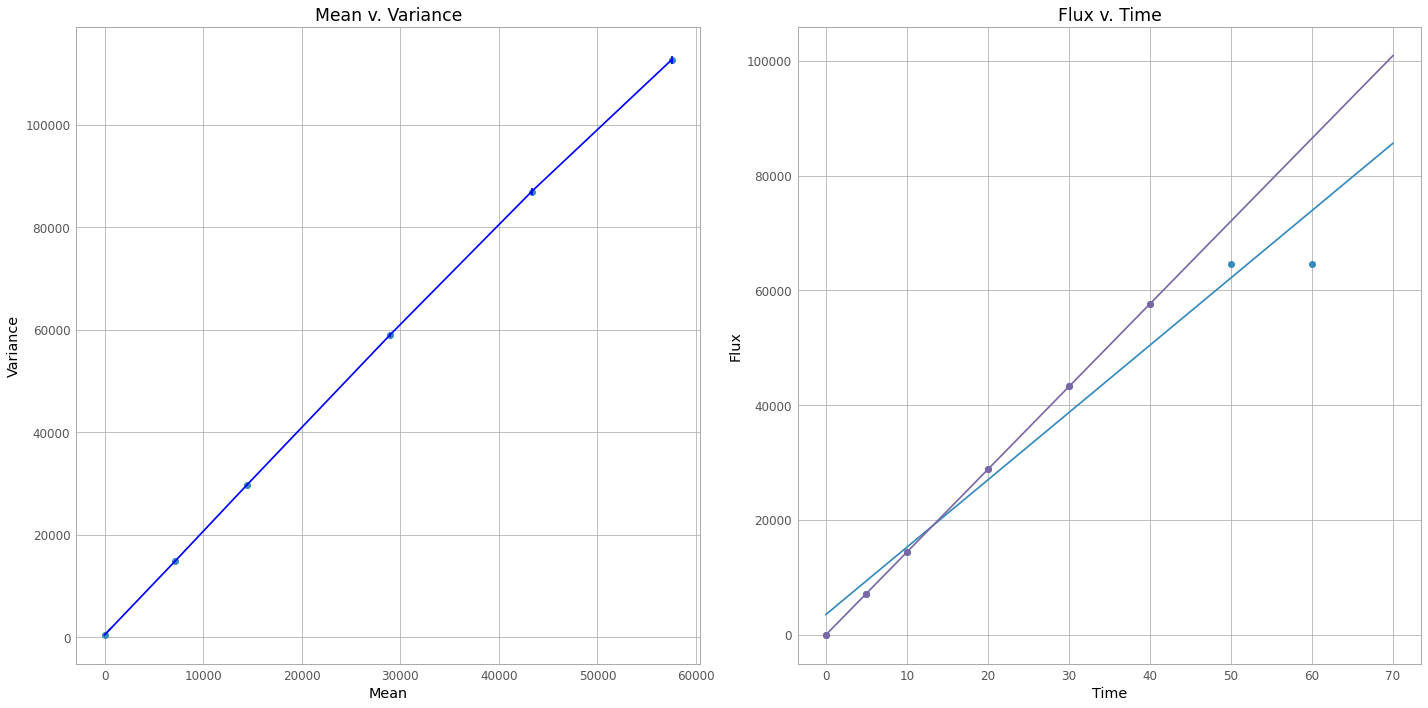

In [ ]:
from scipy.optimize import curve_fit

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 10))

################################################################################



################################################################################

# Setup arrays and data paths to parse()
mean_t = []
var_t = []
paths = ["/*flat5.fit", "/*flat10.fit", "/*flat20.fit", "/*flat30.fit", 
         "/*flat40.fit", "/*flat50.fit", "/*flat60.fit"]

# Extract list of stdevs and means from all data paths
def parse(searchstring,):
  data_cube,data_cube_raw = read_datacube(searchstring,subarray=subarray)
  dims=data_cube.shape
  all_var_list = np.zeros((dims[0],dims[1]))
  all_mean_list = np.zeros((dims[0],dims[1]))
  for i in range(dims[0]):
    for j in range(dims[1]):
      datalist = data_cube[i,j,:]-master_bias[i,j]
      all_var_list[i,j]=np.std(datalist,ddof=1)
      all_mean_list[i,j]=datalist.mean()
  return all_var_list, all_mean_list

# Find mean, variance, and error from each datapath's mean/stdev lists
# Then append to a list of all means and vars to plot later

# Bias
meanb = np.mean(bias_means_list2)
var_listb = bias_rms_list2**2
varb = np.mean(var_listb)
mean_t.append(meanb)
var_t.append(varb)
errb = np.std(var_listb)/np.sqrt(var_listb.size)

# Flat_5
rms_list5, mean_list5 = parse(datapath+paths[0])
mean5 = np.mean(mean_list5)
var_list5 = rms_list5**2
var5 = np.mean(var_list5)
mean_t.append(mean5)
var_t.append(var5)
err5 = np.std(var_list5)/np.sqrt(var_list5.size)

# Flat_10
rms_list10, mean_list10 = parse(datapath+paths[1])
mean10 = np.mean(mean_list10)
var_list10 = rms_list10**2
var10 = np.mean(var_list10)
mean_t.append(mean10)
var_t.append(var10)
err10 = np.std(var_list10)/np.sqrt(var_list10.size)

# Flat_20
rms_list20, mean_list20 = parse(datapath+paths[2])
mean20 = np.mean(mean_list20)
var_list20 = rms_list20**2
var20 = np.mean(var_list20)
mean_t.append(mean20)
var_t.append(var20)
err20 = np.std(var_list20)/np.sqrt(var_list20.size)

# Flat_30
rms_list30, mean_list30 = parse(datapath+paths[3])
mean30 = np.mean(mean_list30)
var_list30 = rms_list30**2
var30 = np.mean(var_list30)
mean_t.append(mean30)
var_t.append(var30)
err30 = np.std(var_list30)/np.sqrt(var_list30.size)

# Flat_40
rms_list40, mean_list40 = parse(datapath+paths[4])
mean40 = np.mean(mean_list40)
var_list40 = rms_list40**2
var40 = np.mean(var_list40)
mean_t.append(mean40)
var_t.append(var40)
err40 = np.std(var_list40)/np.sqrt(var_list40.size)

# Flat_50
rms_list50, mean_list50 = parse(datapath+paths[5])
mean50 = np.mean(mean_list50)
var_list50 = rms_list50**2
var50 = np.mean(var_list50)
mean_t.append(mean50)
var_t.append(var50)
err50 = np.std(var_list50)/np.sqrt(var_list50.size)

# Flat_60
rms_list60, mean_list60 = parse(datapath+paths[6])
mean60 = np.mean(mean_list60)
var_list60 = rms_list60**2
var60 = np.mean(var_list60)
mean_t.append(mean60)
var_t.append(var60)
err60 = np.std(var_list60)/np.sqrt(var_list60.size)

print(mean_t)

# Add all individual errors to a list of total errors
err_t = [errb, err5, err10, err20, err30, err40, err50, err60]
err_t = np.asarray(err_t)


################################################################################




################################################################################

# Plot error bars on the Mean v. Variance data
ax1.errorbar(mean_t[:-2], var_t[:-2], yerr=err_t[:-2], fmt='b' )
ax1.scatter(mean_t[:-2], var_t[:-2]) 

# Provide a linear fit to the Mean v. Variance data with weighted errors
# Include bias frame to anchor y-int
m, b = np.polyfit(mean_t[:-2], var_t[:-2], 1, w = 1/(err_t[:-2]**2)) 
mean2 = np.linspace(0, 700)
ax1.plot(mean2, m*mean2+b)

# Graph Flux v. Time graph with saturated values
time = [0, 5, 10, 20, 30, 40, 50, 60]
time = np.asarray(time)
mean_t = np.asarray(mean_t)
ax2.scatter(time, mean_t)

# Fit for Flux v. Time with saturated values 
m2, b2 = np.polyfit(time, mean_t, 1.0)
time2 = np.linspace(0, 70)
ax2.plot(time2, m2*time2 +b2)  

# Graph Flux v. Time without saturated values
time2 = [0, 5, 10, 20, 30, 40]
ax2.scatter(time2, mean_t[:-2])

# Fit for Flux v. Time without saturated values 
m3, b3 = np.polyfit(time2, mean_t[:-2], 1.0)
time3 = np.linspace(0, 70)
ax2.plot(time3, m3*time3 +b3) 

# Graph details
ax1.set_xlabel('Mean')
ax1.set_ylabel('Variance')
ax2.set_xlabel('Time')
ax2.set_ylabel('Flux')
ax1.set_title('Mean v. Variance')
ax2.set_title('Flux v. Time')
fig.tight_layout()

# Print fit results
print('\n','\n','\n')
print('                                  Fit Results:')
print('\n')

print("Best fit line (mean v var) is y =", m, 'x +', b )
print("Best fit line (time v flux (saturated)) is y =", m2, 'x +', b2 )
print("Best fit line (time v flux (unsaturated)) is y =", m3, 'x +', b3 )

# Find uncertainty on slope and y-int fit values
m, b = np.polyfit(mean_t[:-2], var_t[:-2], 1, w = 1/(err_t[:-2]**2), cov=True) 
print("Mean v. Variance Slope: {} +/- {}".format(m[0], np.sqrt(b[0][0])))
print("Mean v. Variance y-int: {} +/- {}".format(m[1], np.sqrt(b[1][1])))

print('\n','\n','\n')


In [ ]:
# Double checking graphed values on the Mean v. Variance plot
print("0: Mean: ", meanb, " Var: ", varb, " err: ", errb, '\n')
print("5: Mean: ", mean5, " Var: ", var5, " err: ", err5, '\n')
print("10: Mean: ", mean10, " Var: ", var10, " err: ", err10, '\n')
print("20: Mean: ", mean20, " Var: ", var20, " err: ", err20, '\n')
print("30: Mean: ", mean30, " Var: ", var30, " err: ", err30, '\n')
print("40: Mean: ", mean40, " Var: ", var40, " err: ", err40, '\n')
print("50: Mean: ", mean50, " Var: ", var50, " err: ", err50, '\n')
print("60: Mean: ", mean60, " Var: ", var60, " err: ", err60, '\n')

0: Mean:  -1.6143530956469484e-16  Var:  442.38423777777774  err:  2.089607836140889 

5: Mean:  7148.65108  Var:  14842.39295  err:  104.99944563533526 

10: Mean:  14407.694119999998  Var:  29660.018139999996  err:  211.90709472336906 

20: Mean:  28934.00424  Var:  58968.044610000004  err:  416.29763827445987 

30: Mean:  43320.640419999996  Var:  86990.27286999999  err:  618.5409063219274 

40: Mean:  57536.26472000001  Var:  112738.21445999999  err:  799.4882993682762 

50: Mean:  64555.76394  Var:  0.0  err:  0.0 

60: Mean:  64555.76394  Var:  0.0  err:  0.0 



Text(0.5, 1.0, 'Flux / Time v. Time to Show Non-Linearity')

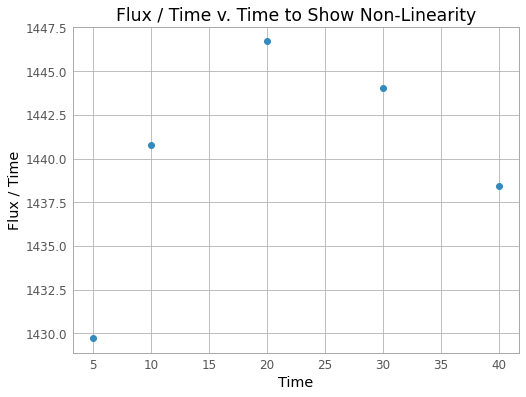

In [ ]:
import matplotlib.pyplot as plt

# Redefining arrays to plot flux v. time v. time to show nonlinearity in 
# unsaturated values 
mean_t0 = [7.14865108e+03, 1.44076941e+04,  2.89340042e+04, 4.33206404e+04,  5.75362647e+04]
time = [5, 10, 20, 30, 40]
time = np.asarray(time)
mean_t = np.asarray(mean_t0)
plt.scatter(time, mean_t0/time)

plt.xlabel('Time')
plt.ylabel('Flux / Time')
plt.title('Flux / Time v. Time to Show Non-Linearity')



In [ ]:
# Define a line function for bootstrapping analysis
def line(x,b,m):
  return b+m*x

# Setup arrays
num_samples =10000
boot_m = np.zeros(num_samples)
boot_b = np.zeros(num_samples) 
num_data=len(mean_t[:-2])

# Setup data 
mean_list_tot = mean_list5 + mean_list10 + mean_list20 + mean_list30 + mean_list40 + mean_list50 + mean_list60
var_list_tot = var_list5 + var_list10 + var_list20 + var_list30 + var_list40 + var_list50 + var_list60
mean_t = np.asarray(mean_t[:-2])
var_t = np.asarray(var_t[:-2])

# Bootstrap method
for i in range(num_samples):
  if (i != 0):
    # resample your data based on estimate of mean and sigma
    # the following is neat trick to quickly pick your random values!
    random_indices = np.random.randint(0,num_data,size=num_data)
    bootstrap_x = mean_t[random_indices]
    bootstrap_y = var_t[random_indices]  
  else:
      bootstrap_x = mean_t # if first call use the ACTUAL DATA!
      bootstrap_y = var_t # if first call use the ACTUAL DATA!

  p0 = [1., 1.] # here we setup a initial guess for the parameters
  coeff, var_matrix = curve_fit(line, bootstrap_x,bootstrap_y, p0=p0)
  boot_m[i]=coeff[0] #save the slope in the array
  boot_b[i]=coeff[1]

# Print results
print("BOOTSTRAP RESULTS")
print('Fitted slope: %5.2f  +/- %5.2f  '%(boot_b[0], boot_b.std()))
print('Fitted y-intercept: %5.2f  +/- %5.2f '%(boot_m[0], boot_m.std()))

ValueError: ignored

In [ ]:
# Gain calculation 
# 1/slope
g = 1/m[0]
g_std = boot_b.std()
print("Gain: {} +/- {} e-/ADU".format(g, g_std))

# Read Noise calculation
# sqrt(y-int)*g for correct units                                                                
sig_RN = np.sqrt(m[1])*g
sig_RN_std = np.sqrt(b[1][1])
print("Read Noise: {} +/- {} e-".format(sig_RN, sig_RN_std))

# Chi Squared calculation
# chi = (data-model)/error
# dof = Number of data points -1 = 5 (w/o saturated values)

chib = ((varb - line(meanb, m[1], m[0]) ) / (errb)) **2
print('\n', 'Chi sq bias = ', chib)

chi5 = (var5 - line(mean5, m[1], m[0]) )**2 / (err5**2)
print('\n', 'Chi sq 5 = ', chi5)

chi10 = (var10 - line(mean10, m[1], m[0]) )**2 / (err10**2)
print('\n', 'Chi sq 10 = ', chi10)

chi20 = (var20 - line(mean20, m[1], m[0]) )**2 / (err20**2)
print('\n', 'Chi sq 20 = ', chi20)

chi30 = (var30 - line(mean30, m[1], m[0]) )**2 / (err30**2)
print('\n', 'Chi sq 30 = ', chi30)

chi40 = (var40 - line(mean40, m[1], m[0]) )**2 / (err40**2)
print('\n', 'Chi sq 40 = ', chi40)

chi50 = (var50 - line(mean50, m[1], m[0]) )**2 / (err50)**2
#print('\n', 'Chi sq 50 = ', chi50)

chi60 = (var60 - line(mean60, m[1], m[0]) )**2 / (err60)**2
#print('\n', 'Chi sq 60 = ', chi60)

# Calculate total chi-squared
chi_sq = (chib + chi5 + chi10 + chi20 + chi30 + chi40)
print('\n', 'Chi Squared = ', chi_sq)

# Calculate total reduced chi-squared 
chi_sq = chi_sq / np.sqrt(6-2)
print('\n', 'Reduced Chi Squared = ', chi_sq, '\n')

# Print data-model information for each frame to double-check 
print("data-model b: ", (varb - line(meanb, m[1], m[0]) ))
print("data-model 5: " ,(var5 - line(mean5, m[1], m[0])  ))
print("data-model 10: " ,(var10 - line(mean10, m[1], m[0])  ))
print("data-model 20: " ,(var20 - line(mean20, m[1], m[0])  ))
print("data-model 30: " ,(var30 - line(mean30, m[1], m[0])  ))
print("data-model 40: " ,(var40 - line(mean40, m[1], m[0])  ))

# Print error information for each frame to double-check 
print('\n')
print("errorb: ", errb)
print("error5: ", err5)
print("error10: ", err10)
print("error20: ", err20)
print("error30: ", err30)
print("error40: ", err40)

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Pixel distribution graph for bias frames and flat field frames

f, axs = plt.subplots(1,1,figsize=(15,10))

# Find best fit of data to apply Gaussian distribution
(mu, sigma) = norm.fit(mean_list_tot)

# The histogram of the data
n, bins, patches = plt.hist(mean_list_tot.ravel(), 200,alpha=0.75, density =1)

# Add a 'best fit' line 
y = norm.pdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)

# Graph details 
plt.xticks(rotation=90)
plt.xlabel("Mean (ADU)")
plt.ylabel("Normalized Counts")
plt.title("Distribution of Pixel Values in Bias and Flat Frames")
plt.show()

# Double-check values 
print(mu)
print(sigma)

In [ ]:
# Pixel distribution graph for bias frames only 

f, axs = plt.subplots(1,1,figsize=(15,10))

# Find best fit of data to apply Gaussian distribution
(mu, sigma) = norm.fit(bias_cube)

# The histogram of the data
n, bins, patches = plt.hist(bias_cube.ravel(), 200,alpha=0.75, density =1)

# Add a 'best fit' line 
y = norm.pdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)

# Graph details 
plt.xticks(rotation=90)
plt.xlabel("Mean (ADU)")
plt.ylabel("Normalized Counts")
plt.title("Distribution of Pixel Values in Bias Frames")
plt.show()

# Double-check values 
print(mu)
print(sigma)

# Closing Comments
Why do the different methods give somewhat different results? 

Which method will you use for your report? -- hint, maybe use one with lowest value...

Remember to estimate errors so you can later estimate errors on the slope and y-intercept fit.  Talk with instructors for some ideas -- also week 4 lecture talked about methods, such as the Monte Carlo and Bootstrap methods.

Write some functions to make your analysis easy to do in jupyter notebooks (similar to the read_datacube())



The main requirement in this lab is to estimate the read noise (in units e-) and the gain (in units
of e-/ADU) of the CCD using the &quot;Mean-Variance Method.&quot; . In addition, you should see if there
is any detectable non-linearity up to the saturation limit.